# Visualising Best Value Wines and Country Statistics
This code calculates the price-to-rating ratio, visualizes it using a box plot to compare different countries, and generates a Plotly graph to present general statistics for each country.

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import seaborn as sns
import plotly.express as px
import pandas as pd

## Price to Rating Ratio
The data in red_wines_final was filtered to identify the best wines at the best prices. A price-to-rating ratio was calculated for each wine to generate a list of the best value options. Additionally, a box plot was created to compare the price-to-rating ratios across countries, highlighting the countries with the best and least value buys.

In [86]:
# Load the red_wines_final database as a dataframe and drop nan values
conn = sqlite3.connect(r'Wine_Raw_Data\red_wines_final.db')
c = conn.cursor()
wine_df = pd.read_sql_query("SELECT * FROM red_wines", conn)
wine_df = wine_df.dropna()

In [87]:
# Remove irrelevant columns
wine_df = wine_df.drop(columns = ['id','url_idx'])

## Filter by Top Countries
The top countries were identified to run our analysis on.

In [88]:
# Get total bottle counts by country
total_bottles = wine_df['Country'].value_counts()

# Calculate the 75th percentile threshold
percentile_threshold = total_bottles.quantile(0.75)

# Filter out countries with bottle counts more than the 75th percentile
top_countries = total_bottles[total_bottles > percentile_threshold]

# add the top countries to a list
countries = top_countries.index.tolist()

# Create a filtered dataframe with data from top countries
filtered_wine_df = wine_df[wine_df['Country'].isin(countries)]

## Filter by Rating
The lowest-rated wines were excluded, and the top 25th percentile based on ratings was selected to focus on higher-quality wines for our analysis.

In [89]:
# calculate the mean and standard deviation from all wines 
mean_rating = wine_df['Rating'].mean()
std_rating = wine_df['Rating'].std()

# Define low ratings as those more than 1 standard deviation below the mean
low_rating_threshold = mean_rating - std_rating

# Filter by low_rating_threshold
filtered_wine_df = filtered_wine_df[filtered_wine_df['Rating'] > low_rating_threshold].sort_values(by = 'Rating', ascending = False)

# Calculate the 25th percentile threshold
low_ratings_threshold = filtered_wine_df['Num_Ratings'].quantile(0.25)

# Filter out wines with number of ratings greater than the 25th percentile
filtered_wine_df = filtered_wine_df[filtered_wine_df['Num_Ratings']>= low_ratings_threshold]

## Create the Price to Ratings Ratio
Normalize the ratings and divide by price to find price-to-ratings ratio and create a list of best values wines

In [90]:
# calculate min and max ratings
min_rating = filtered_wine_df['Rating'].min()
max_rating = filtered_wine_df['Rating'].max()

# Create a column for normalized ratings and calculate the rating-to-price ratio
filtered_wine_df['Normalized_Rating'] = (filtered_wine_df['Rating'] - min_rating) / (max_rating - min_rating)
filtered_wine_df['ratings_to_price_ratio'] = filtered_wine_df['Normalized_Rating'] / filtered_wine_df['Price']

# Sort by 'ratings_to_price__ratio' and get the top 10
filtered_wine_df = filtered_wine_df.sort_values(by = 'ratings_to_price_ratio', ascending = False)
filtered_wine_df = filtered_wine_df.reset_index(drop = True)

# Display list of best valued wines
filtered_wine_df.head()

,Producer,WineType,Year,Region,Country,URL,Rating,Num_Ratings,Price,Normalized_Rating,ratings_to_price_ratio
0,Lavradores de Feitoria,Douro Tinto,2021.0,Douro,Portugal,https://www.vivino.com/lavradores-de-feitoria-...,4.2,295,15.75,0.333333,0.021164
1,Cassini,Godfather Red,2021.0,Okanagan Valley,Canada,https://www.vivino.com/cassini-okanagan-valley...,4.4,160,26.59,0.555556,0.020893
2,Alma Negra,M Blend,2017.0,Mendoza,Argentina,https://www.vivino.com/alma-negra-m-blend/w/11...,4.4,4746,28.39,0.555556,0.019569
3,Road 31 Wine Co.,Pinot Noir,2023.0,Napa Valley,United States,https://www.vivino.com/road-31-wine-co-pinot-n...,4.4,569,29.80,0.555556,0.018643
4,Seven Stones,Cabernet Sauvignon,2019.0,Napa Valley,United States,https://www.vivino.com/seven-stones-us-caberne...,4.6,553,43.39,0.777778,0.017925


## Visualise Best Vlue Wines
A box plot was created to find the countries with the best and least value wines.

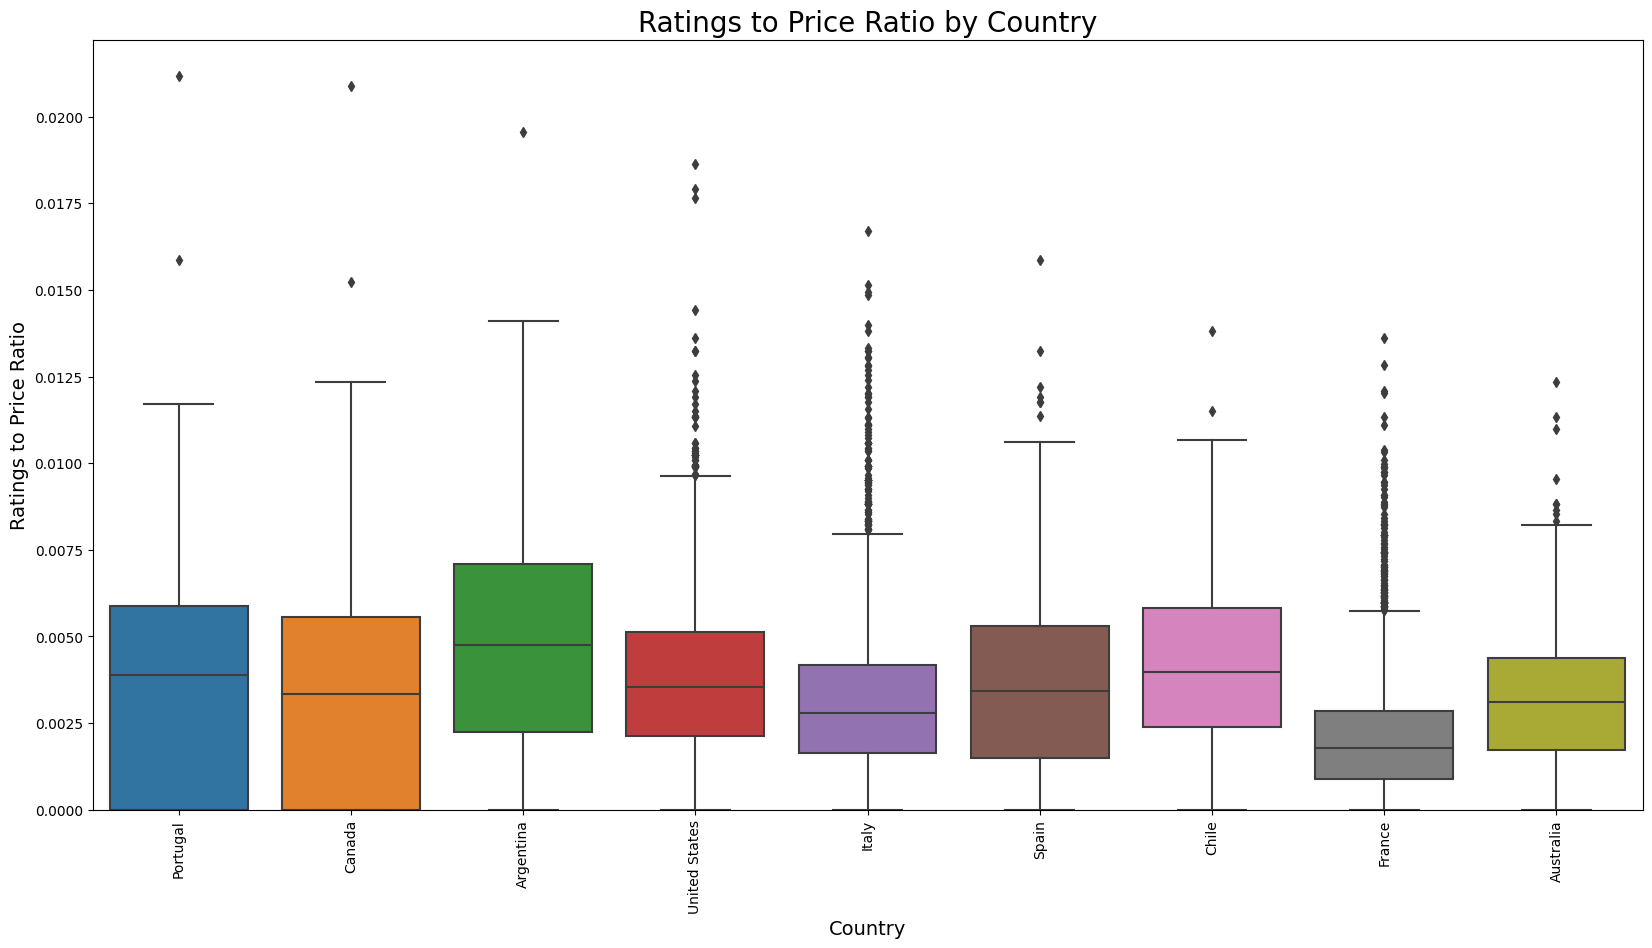

In [91]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Country', y='ratings_to_price_ratio', data=filtered_wine_df)
plt.xlabel("Country", fontsize = 14)
plt.ylabel("Ratings to Price Ratio", fontsize = 14)
plt.title("Ratings to Price Ratio by Country", fontsize = 20)
plt.xticks(rotation=90)
plt.ylim(bottom=0)

plt.show()

# Statsistics Map
In addition to best valued wines a Plotly map was created to display general statsistics for each of our popular countries.

In [92]:
# import Wine_districts_lat_lon.csv to pull a list of countries that were used in our analyses
dist_df = pd.read_csv('Final_DataFrames\Wine_districts_lat_lon.csv')
countries = dist_df['Country'].unique().tolist()

In [93]:
# create a dataframe from all_filtered_winebottle_v1 run our analysis on all vintage bottle data
all_wines_df = pd.read_csv(r'Final_Wines_Of_Interest\all_filtered_winebottle_v1.csv')

## Country Statistics
General statistics were collected for the top countries in our dataset. 

In [94]:
# Filter the DataFrame to include only the specified countries and group the data by country
country_statistics = all_wines_df[all_wines_df['Country'].isin(countries)].groupby('Country').agg(
    Wine_Count=('Country', 'value_counts'),
    Tannin_Mean=('Tannin', 'mean'),
    Acidity_Mean=('Acidity', 'mean'),
    Intensity_Mean=('Intensity', 'mean'),
    Sweetness_Mean=('Sweetness', 'mean'),
    Price = ('amount', 'mean'),
    Rating = ('ratings_average', 'mean')    
    )

country_statistics = country_statistics.round(2)
country_statistics = country_statistics.reset_index(drop = False)

In [95]:
# Find the price to ratio average for each country
price_country_statistics = filtered_wine_df[filtered_wine_df['Country'].isin(countries)].groupby('Country').agg(
    Price_to_rating = ('ratings_to_price_ratio', 'mean')
    )
price_country_statistics = price_country_statistics.sort_values(by = 'Price_to_rating')

In [96]:
# Merge the dataframes to create a final statistics dataframe
merged_statistics_df = pd.merge(price_country_statistics, country_statistics, on = 'Country')
merged_statistics_df = merged_statistics_df.sort_values(by = 'Country')
merged_statistics_df = merged_statistics_df.reset_index(drop = True)

## Identifying Min and Max Satistics
The countries with the lowest and highest statistic were organized and sorted in a dataframe. 

In [97]:
columns = merged_statistics_df.columns[1:]  # Exclude the 'Country' column

# Initialize an empty list to store the results
result = []

# Loop through each column to identify the countries with min and max values
for col in columns:
    result.append([merged_statistics_df.loc[merged_statistics_df[col].idxmin(), 'Country'], f"{col} Min"])
    result.append([merged_statistics_df.loc[merged_statistics_df[col].idxmax(), 'Country'], f"{col} Max"])

# Convert the result into a DataFrame
result_df = pd.DataFrame(result, columns=["Country", "Statistic"])
result_df = result_df.sort_values(by = 'Country' )
print(result_df)

          Country            Statistic
1       Argentina  Price_to_rating Max
11      Argentina   Sweetness_Mean Max
2          Canada       Wine_Count Min
8          Canada   Intensity_Mean Min
10         Canada   Sweetness_Mean Min
12         Canada            Price Min
4           Chile      Tannin_Mean Min
6           Chile     Acidity_Mean Min
14          Chile           Rating Min
0          France  Price_to_rating Min
7          France     Acidity_Mean Max
13         France            Price Max
3           Italy       Wine_Count Max
9        Portugal   Intensity_Mean Max
5           Spain      Tannin_Mean Max
15  United States           Rating Max


In [98]:
# Create a statistics column with data for each country
merged_statistics_df['Statistics'] = ['Best Value <br>Most Sweet', 
                           "Down Unda", 
                           'Least Intense <br>Least Sweet', 
                           'Least Tannic, <br>Least Acidic', 
                           'Worst Value! <br>Most Acidic', 
                           'Most Popular', 
                           'Highest Intensity', 
                           'Most Tannic', 
                           'Highest Rated']

## 

## Country Map and Statistics
A final map was created to show the top countries and display their general statistics through a hover feature. 

In [100]:
# Add a uniform colour column for all countries
merged_statistics_df['Color'] = 1  # All countries have the same colour initially

# Create the choropleth map
fig = px.choropleth(
    data_frame=merged_statistics_df,
    locations="Country",
    locationmode="country names",
    color="Color",
    color_continuous_scale="Reds",
    range_color=(0.5, 1.5),
    title="Countries and Statistics",
    hover_data=["Country", "Statistics"]
)

# Update the layout to set the colour for countries not in the DataFrame
fig.update_geos(
    showcoastlines=True,
    showland=True,
    landcolor="lightgray",
    showocean=True,
    oceancolor="lightblue",
    showcountries=True
)

# Add dropdown functionality to adjust color values
fig.update_layout(
    hoverlabel=dict(
        bgcolor="Dark Grey",  
        font_size=16,     
        font_family="Arial",  
        font_color="white",  
        bordercolor="white",  
        font_weight="bold"  
    ),
    updatemenus=[
        {
            'buttons': [
                {
                    'label': 'Show All',
                    'method': 'update',
                    'args': [
                        {'z': [merged_statistics_df['Color']]},  # Reset all countries to full color
                    ]
                }
            ] + [
                {
                    'label': country,
                    'method': 'update',
                    'args': [
                        {'z': [merged_statistics_df['Color'].where(
                            merged_statistics_df['Country'] == country, 0.7)]},  # Highlight selected country
                        {'color_continuous_scale': "Reds",}  # Reds gradient for the selected country
                    ]
                }
                for country in merged_statistics_df['Country']
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.3,
            'xanchor': 'center',
            'y': 1.1,
            'yanchor': 'top',
            
        }
    ]
)

# Remove margins for better display
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_layout(coloraxis_showscale=False, title_x=0.5)


# Show the plot
fig.show()
fig.write_html(r"Pictures\plotly_chart.html")
